# FAKE NEWS CLASSIFIER

In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
import re
pd.set_option('max_colwidth', 800)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#learning word embeddings on training data using Gensim library
from gensim.models import Word2Vec, KeyedVectors
# gensim modules
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

In [ ]:
#loading dataset
d1=pd.read_csv('/content/drive/MyDrive/Fake.csv')
d1.head()

title  ...               date
0              Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing  ...  December 31, 2017
1                        Drunk Bragging Trump Staffer Started Russian Collusion Investigation  ...  December 31, 2017
2   Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’  ...  December 30, 2017
3               Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES)  ...  December 29, 2017
4                       Pope Francis Just Called Out Donald Trump During His Christmas Speech  ...  December 25, 2017

[5 rows x 4 columns]

In [ ]:
d2=pd.read_csv('/content/drive/MyDrive/True.csv')
d2.head()

title  ...                date
0       As U.S. budget fight looms, Republicans flip their fiscal script  ...  December 31, 2017 
1       U.S. military to accept transgender recruits on Monday: Pentagon  ...  December 29, 2017 
2           Senior U.S. Republican senator: 'Let Mr. Mueller do his job'  ...  December 31, 2017 
3            FBI Russia probe helped by Australian diplomat tip-off: NYT  ...  December 30, 2017 
4  Trump wants Postal Service to charge 'much more' for Amazon shipments  ...  December 29, 2017 

[5 rows x 4 columns]

In [ ]:
d1['label'] = 0 # for fake news
d2['label'] = 1 # for true news

## DATA CLEANING AND EDA

#### DATA CLEANING FOR DATASET I

Noticed some words in fake dataset that are present in the true dataset. [BOILER ROOM:, WARNING:, FLASHBACK:, VIDEO:, WATCH!, BREAKING:, WATCH:, REPORT:, WATCH AND LAUGH:, BREAKING NEWS:, UPDATED VIDEO:, UPDATE:, SHOCKING:, POLL:, Factbox:]. These words are present in the start. e.g WATCH: Paul Ryan Just Told Us. So these words do not use for prediction (whether the news is fake or not). So making this with the empty string.

In [ ]:
d1['title'] = d1['title'].str.replace('BOILER ROOM:', '')
d1['title'] = d1['title'].str.replace('WARNING:', '')
d1['title'] = d1['title'].str.replace('FLASHBACK:', '')
d1['title'] = d1['title'].str.replace('VIDEO:', '')
d1['title'] = d1['title'].str.replace('BREAKING:', '')
d1['title'] = d1['title'].str.replace('BREAKING NEWS:', '')
d1['title'] = d1['title'].str.replace('WATCH:', '')
d1['title'] = d1['title'].str.replace('REPORT: ', '')
d1['title'] = d1['title'].str.replace('WATCH AND LAUGH:', '')
d1['title'] = d1['title'].str.replace('UPDATE:', '')
d1['title'] = d1['title'].str.replace('SHOCKING:', '')
d1['title'] = d1['title'].str.replace('POLL:', '')
d1['title'] = d1['title'].str.replace('WATCH!', '')
d1['title'] = d1['title'].str.replace('UPDATED VIDEO:', '')
d1['title'] = d1['title'].str.replace('Factbox:', '')

#### DATA CLEANIN FOR DATASET II

In [ ]:
# 'factbox:'. so removing them
d2['title'] = d2['title'].str.replace('Factbox:', '')

Difference in Text

Real news seems to have source of publication which is not present in fake news set

Looking at the data:

    1. Most of text contains reuters information such as "WASHINGTON (Reuters)".
    2. Some text are tweets from Twitter.
    3. Few text do not contain any publication info.



In [ ]:
#First Creating list of index that do not have publication part
unknown_publishers = []
for index,row in enumerate(d2.text.values):
    try:
        record = row.split(" -", maxsplit=1)
        #if no text part is present, following will give error
        record[1]
        #if len of piblication part is greater than 260
        #following will give error, ensuring no text having "-" in between is counted
        assert(len(record[0]) < 260)
    except:
        unknown_publishers.append(index)

In [ ]:
#Thus we have list of indices where publisher is not mentioned
#lets check
d2.iloc[unknown_publishers].text
#true, they do not have text like "WASHINGTON (Reuters)"

3488     The White House on Wednesday disclosed a group of former lobbyists working in President Donald Trump’s administration who have been issued ethics waivers, following a request from the U.S. government’s ethics agency. The list of at least 11 waivers include White House adviser Kellyanne Conway and Trump's Chief of Staff Reince Priebus, according to a chart issued on the White House website. (bit.ly/1LPKWx8) Conway is permitted to “participate in communications and meetings involving former clients which are political, advocacy, trade or non-profit organizations,” while Priebus, a former Republican National Committee chairman, is allowed to have communications and meetings with the RNC, the document says. Shortly after taking office in January, Trump signed an executive order barring lob...
4358     Neil Gorsuch, President Donald Trump’s appointee to the U.S. Supreme Court who was confirmed by the Senate to the lifetime job on Friday in a 54-45 vote, will have an immediate impac

In [ ]:
#Seperating Publication info, from actual text
publisher = []
tmp_text = []
for index,row in enumerate(d2.text.values):
    if index in unknown_publishers:
        #Add unknown of publisher not mentioned
        tmp_text.append(row)
        
        publisher.append("Unknown")
        continue
    record = row.split(" -", maxsplit=1)
    publisher.append(record[0])
    tmp_text.append(record[1])

In [ ]:
#Replace existing text column with new text
#add seperate column for publication info
d2["publisher"] = publisher
d2["text"] = tmp_text

del publisher, tmp_text, record, unknown_publishers

In [ ]:
d2.head()

title  ...                     publisher
0       As U.S. budget fight looms, Republicans flip their fiscal script  ...          WASHINGTON (Reuters)
1       U.S. military to accept transgender recruits on Monday: Pentagon  ...          WASHINGTON (Reuters)
2           Senior U.S. Republican senator: 'Let Mr. Mueller do his job'  ...          WASHINGTON (Reuters)
3            FBI Russia probe helped by Australian diplomat tip-off: NYT  ...          WASHINGTON (Reuters)
4  Trump wants Postal Service to charge 'much more' for Amazon shipments  ...  SEATTLE/WASHINGTON (Reuters)

[5 rows x 6 columns]

In [ ]:
d2['publisher'].value_counts()

WASHINGTON (Reuters)                         6389
(Reuters)                                    1483
LONDON (Reuters)                              705
NEW YORK (Reuters)                            695
MOSCOW (Reuters)                              623
                                             ... 
BEIRUT/ERBIL (Reuters)                          1
WASHINGTON/ABOARD AIR FORCE ONE (Reuters)       1
SACRAMENTO, Calif./NEW YORK (Reuters)           1
ALGIERS/PARIS (Reuters)                         1
OTTAWA/WASHINGTON (Reuters)                     1
Name: publisher, Length: 1692, dtype: int64

In [ ]:
d2.drop(['publisher'], axis=1, inplace=True)
d2.head()

title  ... label
0       As U.S. budget fight looms, Republicans flip their fiscal script  ...     1
1       U.S. military to accept transgender recruits on Monday: Pentagon  ...     1
2           Senior U.S. Republican senator: 'Let Mr. Mueller do his job'  ...     1
3            FBI Russia probe helped by Australian diplomat tip-off: NYT  ...     1
4  Trump wants Postal Service to charge 'much more' for Amazon shipments  ...     1

[5 rows x 5 columns]

In [ ]:
# combining the two datasets or concatenating the two dataset.
frame = [d1, d2]
df = pd.concat(frame)
df.head()

title  ... label
0              Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing  ...     0
1                        Drunk Bragging Trump Staffer Started Russian Collusion Investigation  ...     0
2   Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’  ...     0
3               Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES)  ...     0
4                       Pope Francis Just Called Out Donald Trump During His Christmas Speech  ...     0

[5 rows x 5 columns]

In [ ]:
df.shape

(44898, 5)

In [ ]:
df.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [ ]:
# dropping duplicates
df = df.drop_duplicates()

In [ ]:
df.head()

title  ... label
0              Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing  ...     0
1                        Drunk Bragging Trump Staffer Started Russian Collusion Investigation  ...     0
2   Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’  ...     0
3               Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES)  ...     0
4                       Pope Francis Just Called Out Donald Trump During His Christmas Speech  ...     0

[5 rows x 5 columns]

In [ ]:
# resetting the index
df.reset_index(inplace=True)

In [ ]:
# after dropping the duplicates, i get 44689 no of rows. So total no of duplicates present in the dataset = 209
df.shape

(44689, 6)

In [ ]:
df.columns

Index(['index', 'title', 'text', 'subject', 'date', 'label'], dtype='object')

In [ ]:
df['subject'].value_counts()

politicsNews       11220
worldnews           9991
News                9050
politics            6838
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: subject, dtype: int64

In [ ]:
df['label'].value_counts()

0    23478
1    21211
Name: label, dtype: int64

In [ ]:
# dropping unnecessary columns. 
df.drop(['subject', 'date'], axis = 1, inplace=True)
df.head()

index  ... label
0      0  ...     0
1      1  ...     0
2      2  ...     0
3      3  ...     0
4      4  ...     0

[5 rows x 4 columns]

In [ ]:
df.columns

Index(['index', 'title', 'text', 'label'], dtype='object')

In [ ]:
df['combine']= df['title'] +' '+ df['text']
df.head()

index  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          combine
0      0  ...   Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 ...
1      1  ...   Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being...
2      2  ...   Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’ On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he later had detained by the police for no reason whatsoever, except that maybe his feelings were hurt. Clarke messaged the police to stop Black after he deplaned, and now, a search warrant has been executed by the FBI to see the exchanges.Clarke is calling it fake news even though copies of the search warrant are on the Internet. I am UNINTIMIDATED by lib media attempts to smear and discredit me with their F...
3      3  ...   Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES) On Christmas day, Donald Trump announced that he would  be back to work  the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at Trump properties.71 rounds of golf including today s. At this pace, he ll pass Obama s first-term total by July 24 next year. https://t.co/Fg7VacxRtJ pic.twitter.com/5gEMcjQTbH  Philip Bump (@pbump) December 29, 2017 That makes what a Washington Post reporter discovered on Trump s website really

In [ ]:
# dropping unnecessary columns. 
df.drop(['index', 'title', 'text'], axis = 1, inplace=True)
df.head()

label                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          combine
0      0   Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that. Instead, he had to give a shout out to his enemies, haters and  the very dishonest fake news media.  The former reality show star had just one job to do and he couldn t do it. As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year,  President Angry Pants tweeted.  2018 will be a great year for America! As our Country rapidly grows stronger and smarter, I want to wish all of my friends, supporters, enemies, haters, and even the very dishonest Fake News Media, a Happy and Healthy New Year. 2018 ...
1      0   Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nunes is going to have a bad day. He s been under the assumption, like many of us, that the Christopher Steele-dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump. As it happens, the dossier is not what started the investigation, according to documents obtained by the New York Times.Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton.On top of that, Papadopoulos wasn t just a covfefe boy for Trump, as his administration has alleged. He had a much larger role, but none so damning as being...
2      0   Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People ‘In The Eye’ On Friday, it was revealed that former Milwaukee Sheriff David Clarke, who was being considered for Homeland Security Secretary in Donald Trump s administration, has an email scandal of his own.In January, there was a brief run-in on a plane between Clarke and fellow passenger Dan Black, who he later had detained by the police for no reason whatsoever, except that maybe his feelings were hurt. Clarke messaged the police to stop Black after he deplaned, and now, a search warrant has been executed by the FBI to see the exchanges.Clarke is calling it fake news even though copies of the search warrant are on the Internet. I am UNINTIMIDATED by lib media attempts to smear and discredit me with their F...
3      0   Trump Is So Obsessed He Even Has Obama’s Name Coded Into His Website (IMAGES) On Christmas day, Donald Trump announced that he would  be back to work  the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at Trump properties.71 rounds of golf including today s. At this pace, he ll pass Obama s first-term total by July 24 next year. https://t.co/Fg7VacxRtJ pic.twitter.com/5gEMcjQTbH  Philip Bump (@pbump) December 29, 2017 That makes what a Washington Post reporter discovered on Trump s website really weird, but everything ab

In [ ]:
# Cleaning Raw tweets
def clean_text(text):
    
    #remove emails
    text = ' '.join([i for i in text.split() if '@' not in i])
    
    #remove web address
    text = re.sub('http[s]?://\S+', '', text)

    #remove brackets and parantheses (and removing the text inside the brackets and parantheses)
    text = re.sub("[\(\[].*?[\)\]]", "", text)

    #remove punctuations
    text = re.sub(r'[^\w\s]', ' ', text)
    
    #Filter to allow only alphabets
    text = re.sub(r'[^a-zA-Z\']', ' ', text)
    
    #Remove Unicode characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    #remove double spaces 
    text = re.sub('\s+', ' ', text)
    
    return text

In [ ]:
# applying that into function.
df["text"] = df['combine'].apply(lambda x: clean_text(x))
df.head(10)

label  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             text
0      0  ...  Donald Trump Sends Out Embarrassing New Year s Eve Message This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that Instead he had to give a shout out to his enemies haters and the very dishonest fake news media The former reality show star had just one job to do and he couldn t do it As our Country rapidly grows stronger and smarter I want to wish all of my friends supporters enemies haters and even the very dishonest Fake News Media a Happy and Healthy New Year President Angry Pants tweeted will be a great year for America As our Country rapidly grows stronger and smarter I want to wish all of my friends supporters enemies haters and even the very dishonest Fake News Media a Happy and Healthy New Year will be a great year for America Dona...
1      0  ...  Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nunes is going to have a bad day He s been under the assumption like many of us that the Christopher Steele dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump As it happens the dossier is not what started the investigation according to documents obtained by the New York Times Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton On top of that Papadopoulos wasn t just a covfefe boy for Trump as his administration has alleged He had a much larger role but none so damning as being a drunken ...
2      0  ...  Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People In The Eye On Friday it was revealed that former Milwaukee Sheriff David Clarke who was being considered for Homeland Security Secretary in Donald Trump s administration has an email scandal of his own In January there was a brief run in on a plane between Clarke and fellow passenger Dan Black who he later had detained by the police for no reason whatsoever except that maybe his feelings were hurt Clarke messaged the police to stop Black after he deplaned and now a search warrant has been executed by the FBI to see the exchanges Clarke is calling it fake news even though copies of the search warrant are on the Internet I am UNINTIMIDATED by lib media attempts to smear and discredit me with their FAKE NEWS repo...
3      0  ...  Trump Is So Obsessed He Even Has Obama s Name Coded Into His Website On Christmas day Donald Trump announced that he would be back to work the following day but he is golfing for the fourth day in a row The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played Updated my tracker of Trump s appearances at Trump properties rounds of golf including today s At this pace he ll pass Obama s first term total by July next year pic twitter com gEMcjQTbH Philip Bump December That makes what a Washington Post reporter discovered on Trump s website really weird but everything about this administration is bizarre AF The co

In [ ]:
# dropping the uncleaned text column "combine"
df = df.drop(['combine'], axis=1)

In [ ]:
df.head()

label                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             text
0      0  Donald Trump Sends Out Embarrassing New Year s Eve Message This is Disturbing Donald Trump just couldn t wish all Americans a Happy New Year and leave it at that Instead he had to give a shout out to his enemies haters and the very dishonest fake news media The former reality show star had just one job to do and he couldn t do it As our Country rapidly grows stronger and smarter I want to wish all of my friends supporters enemies haters and even the very dishonest Fake News Media a Happy and Healthy New Year President Angry Pants tweeted will be a great year for America As our Country rapidly grows stronger and smarter I want to wish all of my friends supporters enemies haters and even the very dishonest Fake News Media a Happy and Healthy New Year will be a great year for America Dona...
1      0  Drunk Bragging Trump Staffer Started Russian Collusion Investigation House Intelligence Committee Chairman Devin Nunes is going to have a bad day He s been under the assumption like many of us that the Christopher Steele dossier was what prompted the Russia investigation so he s been lashing out at the Department of Justice and the FBI in order to protect Trump As it happens the dossier is not what started the investigation according to documents obtained by the New York Times Former Trump campaign adviser George Papadopoulos was drunk in a wine bar when he revealed knowledge of Russian opposition research on Hillary Clinton On top of that Papadopoulos wasn t just a covfefe boy for Trump as his administration has alleged He had a much larger role but none so damning as being a drunken ...
2      0  Sheriff David Clarke Becomes An Internet Joke For Threatening To Poke People In The Eye On Friday it was revealed that former Milwaukee Sheriff David Clarke who was being considered for Homeland Security Secretary in Donald Trump s administration has an email scandal of his own In January there was a brief run in on a plane between Clarke and fellow passenger Dan Black who he later had detained by the police for no reason whatsoever except that maybe his feelings were hurt Clarke messaged the police to stop Black after he deplaned and now a search warrant has been executed by the FBI to see the exchanges Clarke is calling it fake news even though copies of the search warrant are on the Internet I am UNINTIMIDATED by lib media attempts to smear and discredit me with their FAKE NEWS repo...
3      0  Trump Is So Obsessed He Even Has Obama s Name Coded Into His Website On Christmas day Donald Trump announced that he would be back to work the following day but he is golfing for the fourth day in a row The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played Updated my tracker of Trump s appearances at Trump properties rounds of golf including today s At this pace he ll pass Obama s first term total by July next year pic twitter com gEMcjQTbH Philip Bump December That makes what a Washington Post reporter discovered on Trump s website really weird but everything about this administration is bizarre AF The coding contained a referenc

In [ ]:
df['label'].value_counts()

0    23478
1    21211
Name: label, dtype: int64

This is perfectly balanced dataset

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


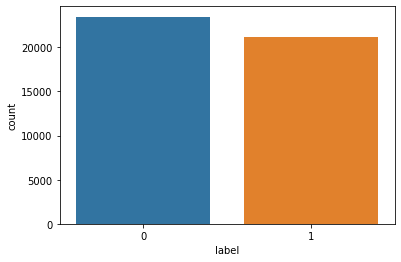

In [ ]:
import seaborn as sns
sns.countplot('label',data=df)

In [ ]:
df.to_csv('data.csv', index=False)

### WORD VISUALIZATION

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [ ]:
#making worldcloud
from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))
print(stop_words)

{'my', "mightn't", 'there', 'been', 'very', 'weren', 'd', 'him', 'into', "couldn't", 'not', 'so', 'before', 'such', 'won', 'wouldn', "it's", 'a', 'needn', 'theirs', 'should', "weren't", "you'll", 'after', 'has', 'on', 've', 'hers', 'its', 'doing', 'be', 'against', 'more', "you've", "you'd", 'them', 'those', 'most', "you're", "hadn't", 'isn', 'again', 'yours', 'couldn', 'than', 'hasn', 'as', 'only', 'out', 'y', 'hadn', 'they', 'while', 'of', 's', "that'll", 'some', 'through', 'during', "don't", 'it', 'how', 'between', 'ours', 'haven', 'ma', 'the', 'did', 'had', 'll', 'her', 'mustn', 'are', 'other', 'your', 'over', 'here', 'have', 'no', 'you', 'was', "won't", 'ourselves', 'nor', "should've", 'she', 'is', 'off', 'when', 'yourselves', 'this', 'itself', "didn't", "haven't", 'me', 'who', 't', 'mightn', 'until', 'yourself', 'herself', 'each', 'up', 'themselves', 'own', 'whom', 'myself', 'do', 'an', 'if', 'below', 'with', 'can', 'am', 'both', 'does', 'to', 'were', 'by', 'having', 'these', 'dow

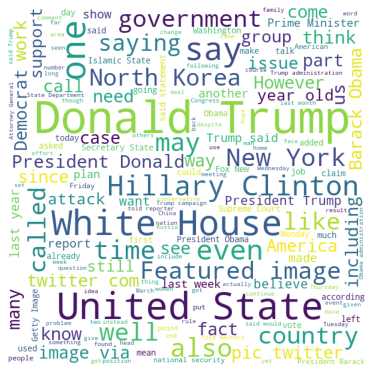

In [ ]:
# visualizing the most frequent words using matplot library
comment_words = ' '
for words in df['text']: 
    comment_words = comment_words + words + ' '
    
wordcloud = WordCloud(width = 600, height = 600, 
                background_color='white' , 
                stopwords = stop_words, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0)

### WORD2VEC - WORD EMBEDDING 

In [ ]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
tokenizer

RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=<RegexFlag.UNICODE|DOTALL|MULTILINE: 56>)

In [ ]:
y = df["label"].values
#Converting X to format acceptable by gensim, removing annd punctuation stopwords in the process
X = []
stop_words = set(nltk.corpus.stopwords.words("english"))
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
for par in df["text"].values:
    tmp = []
    sentences = nltk.sent_tokenize(par)
    for sent in sentences:
        sent = sent.lower()
        tokens = tokenizer.tokenize(sent)
        filtered_words = [w.strip() for w in tokens if w not in stop_words and len(w) > 1]
        tmp.extend(filtered_words)
    X.append(tmp)

In [ ]:
X

[['donald',
  'trump',
  'sends',
  'embarrassing',
  'new',
  'year',
  'eve',
  'message',
  'disturbing',
  'donald',
  'trump',
  'wish',
  'americans',
  'happy',
  'new',
  'year',
  'leave',
  'instead',
  'give',
  'shout',
  'enemies',
  'haters',
  'dishonest',
  'fake',
  'news',
  'media',
  'former',
  'reality',
  'show',
  'star',
  'one',
  'job',
  'country',
  'rapidly',
  'grows',
  'stronger',
  'smarter',
  'want',
  'wish',
  'friends',
  'supporters',
  'enemies',
  'haters',
  'even',
  'dishonest',
  'fake',
  'news',
  'media',
  'happy',
  'healthy',
  'new',
  'year',
  'president',
  'angry',
  'pants',
  'tweeted',
  'great',
  'year',
  'america',
  'country',
  'rapidly',
  'grows',
  'stronger',
  'smarter',
  'want',
  'wish',
  'friends',
  'supporters',
  'enemies',
  'haters',
  'even',
  'dishonest',
  'fake',
  'news',
  'media',
  'happy',
  'healthy',
  'new',
  'year',
  'great',
  'year',
  'america',
  'donald',
  'trump',
  'december',
  'tr

In [ ]:
import gensim

In [ ]:
#Dimension of vectors we are generating
EMBEDDING_DIM = 100

#Creating Word Vectors by Word2Vec Method (takes time...)
w2v_model = gensim.models.Word2Vec(sentences=X, size=EMBEDDING_DIM, window=5, min_count=1)

In [ ]:
#vocab size
len(w2v_model.wv.vocab)

#We have now represented each of 103360 words by a 100dim vector.

103360

In [ ]:
#see a sample vector for random word, lets say 'Trump'
w2v_model["trump"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([-0.30547702,  1.4220072 , -0.28946954, -0.3847718 ,  0.29458383,
       -0.05055987, -0.42042664, -0.36663908,  1.6803823 ,  1.1402335 ,
       -0.7634708 ,  1.0342927 ,  3.6622858 , -1.3781992 , -2.2699742 ,
        0.44982713,  0.9762409 , -0.6834254 ,  0.65807796, -0.20190191,
       -0.9085915 , -1.1429585 ,  0.90086114, -0.12870543,  1.178345  ,
       -0.16183682, -1.1051798 , -0.14411233, -1.2540753 , -3.9472756 ,
       -0.9926525 ,  0.16485868, -0.76375043,  1.6450018 , -2.1370432 ,
       -1.1273094 ,  2.4081433 , -0.49758184, -1.481503  ,  0.75193894,
       -0.0813135 ,  3.7774937 ,  0.07958256, -1.3546761 , -1.3730867 ,
        0.8181426 ,  0.7309888 , -1.1197622 , -1.0317165 ,  0.5339365 ,
        0.22749934,  0.05968411,  0.6319524 ,  0.20417203, -0.170058  ,
        1.3969369 ,  0.5877185 ,  1.4984359 ,  4.764795  , -2.5213528 ,
       -0.99186337,  1.9370341 ,  0.5469618 ,  0.02784445, -1.4657768 ,
       -0.85476965, -0.5282536 ,  2.7106242 ,  1.1009468 , -1.89

In [ ]:
w2v_model["president"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([-0.42589653,  2.923311  ,  1.7683319 , -3.1528277 ,  0.02847151,
        0.30702066, -2.0132234 , -0.33105484, -0.36325976,  2.0921874 ,
       -0.13490377,  0.62685794,  1.4704427 ,  1.251501  , -0.3424604 ,
        0.12495647, -0.6119568 ,  0.3556177 ,  1.5041758 ,  0.22397278,
        0.74165535, -1.0809507 ,  1.9127331 ,  0.6627387 , -1.2004722 ,
        0.9283979 , -0.23111089,  0.8568199 , -0.6301564 , -2.528719  ,
       -0.22972974,  1.2938749 , -0.32626206,  0.8040733 , -0.39240095,
       -0.4750594 ,  1.7551029 , -2.4829814 ,  1.3612549 ,  3.0623538 ,
       -1.1346759 ,  5.0344872 , -2.4043198 ,  0.523678  , -2.717236  ,
        1.3191079 , -1.2578824 , -1.8082392 , -2.1127906 , -1.5136933 ,
        1.1877011 ,  1.472749  ,  0.7686802 , -1.9091903 , -0.29406497,
       -0.427061  ,  1.1980004 ,  1.2821081 ,  4.8842206 , -0.28142   ,
       -3.9736555 ,  2.9093122 , -0.15623301,  1.0197223 , -1.2360239 ,
        0.8060228 ,  0.76099205, -0.43913147,  0.9398749 , -0.17

In [ ]:
w2v_model.wv.most_similar("election")

[('elections', 0.8343127369880676),
 ('electoral', 0.6445858478546143),
 ('primaries', 0.6348372101783752),
 ('nominating', 0.5950815677642822),
 ('primary', 0.584618330001831),
 ('nomination', 0.5770739316940308),
 ('contest', 0.5547209978103638),
 ('race', 0.5470226407051086),
 ('recount', 0.5385395288467407),
 ('hotly', 0.5222355127334595)]

In [ ]:
w2v_model.wv.most_similar("clinton")

[('crooked', 0.6591445207595825),
 ('ckkkk', 0.575624406337738),
 ('preformed', 0.5752336978912354),
 ('mansplained', 0.5601966381072998),
 ('cinton', 0.5442958474159241),
 ('dmlol', 0.5384929180145264),
 ('clintons', 0.5334784984588623),
 ('skojec', 0.5261876583099365),
 ('aplenty', 0.5241533517837524),
 ('feesas', 0.521367609500885)]



Looking at the similar words, vectors are well formed for these words :)

These Vectors will be passed to LSTM/GRU instead of words. 
Keras has implementation called "Embedding Layer" which would create word embeddings(vectors). Since we did that with gensim's word2vec, we will load these vectors into embedding layer and make the layer non-trainable.

We cannot pass string words to embedding layer, thus need some way to represent each words by numbers.

Tokenizer can represent each word by number


In [ ]:
# Tokenizing Text -> Repsesenting each word by a number
# Mapping of orginal word to number is preserved in word_index property of tokenizer

#Tokenized applies basic processing like changing it to lower case, explicitely setting that as False
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

In [ ]:
# lets check the first 50 words of first news
#every word has been represented with a number
X[0][:50]

[13,
 1,
 4647,
 2561,
 8,
 17,
 4284,
 513,
 2627,
 13,
 1,
 2300,
 115,
 1480,
 8,
 17,
 528,
 412,
 297,
 7493,
 2977,
 7912,
 4546,
 493,
 27,
 36,
 32,
 817,
 136,
 849,
 6,
 335,
 33,
 4480,
 9149,
 2710,
 10384,
 93,
 2300,
 826,
 221,
 2977,
 7912,
 34,
 4546,
 493,
 27,
 36,
 1480,
 3997]

In [ ]:
#Lets check few word to numerical replesentation
#Mapping is preserved in dictionary -> word_index property of instance
word_index = tokenizer.word_index
for word, num in word_index.items():
    print(f"{word} -> {num}")
    if num == 10:
        break    

trump -> 1
said -> 2
president -> 3
would -> 4
people -> 5
one -> 6
state -> 7
new -> 8
obama -> 9
also -> 10


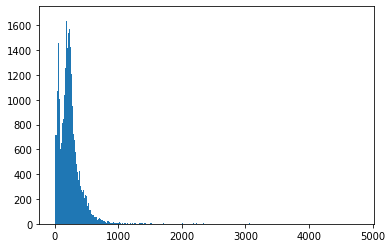

In [ ]:
# For determining size of input...

# Making histogram for no of words in news shows that most news article are under 700 words.
# Lets keep each news small and truncate all news to 700 while tokenizing
plt.hist([len(x) for x in X], bins=500)
plt.show()

# Its heavily skewed. There are news with 5000 words. Lets truncate these outliers :) 

In [ ]:
nos = np.array([len(x) for x in X])
len(nos[nos  < 800])
# Out of 44k news, 44k have less than 800 words

44157

In [ ]:
#Lets keep all news to 800, add padding to news with less than 800 words and truncating long ones
maxlen = 800 

#Making all news of size maxlen defined above
X = pad_sequences(X, maxlen=maxlen)

In [ ]:
X

array([[    0,     0,     0, ..., 10385,   439,   387],
       [    0,     0,     0, ...,  5358,   439,   387],
       [    0,     0,     0, ...,  7464,   439,   387],
       ...,
       [    0,     0,     0, ...,   619,  3857,     2],
       [    0,     0,     0, ...,   380,   565,  8998],
       [    0,     0,     0, ...,  5549,   227,   358]], dtype=int32)

In [ ]:
#all news has 800 words (in numerical form now). If they had less words, they have been padded with 0
# 0 is not associated to any word, as mapping of words started from 1
# 0 will also be used later, if unknows word is encountered in test set
len(X[0])

800

In [ ]:
# Adding 1 because of reserved 0 index
# Embedding Layer creates one more vector for "UNKNOWN" words, or padded words (0s). This Vector is filled with zeros.
# Thus our vocab size inceeases by 1
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
# Function to create weight matrix from word2vec gensim model
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # define weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model[word]
    return weight_matrix



We Create a matrix of mapping between word-index and vectors. We use this as weights in embedding layer

Embedding layer accepts numecical-token of word and outputs corresponding vercor to inner layer.

It sends vector of zeros to next layer for unknown words which would be tokenized to 0.

Input length of Embedding Layer is the length of each news (800 now due to padding and truncating)


In [ ]:
#Getting embedding vectors from word2vec and usings it as weights of non-trainable keras embedding layer
embedding_vectors = get_weight_matrix(w2v_model, word_index)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


### MODEL BUILDING

In [ ]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 800, 100)          10336100  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 10,453,477
Trainable params: 117,377
Non-trainable params: 10,336,100
_________________________________________________________________


In [ ]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y) 

In [ ]:
model.fit(X_train, y_train, validation_split=0.2, epochs=8)

Epoch 1/8
838/838 [==============================] - 661s 785ms/step - loss: 0.1245 - acc: 0.9571 - val_loss: 0.0780 - val_acc: 0.9743
Epoch 2/8
838/838 [==============================] - 655s 782ms/step - loss: 0.0816 - acc: 0.9718 - val_loss: 0.0554 - val_acc: 0.9796
Epoch 3/8
838/838 [==============================] - 674s 804ms/step - loss: 0.0515 - acc: 0.9821 - val_loss: 0.0541 - val_acc: 0.9812
Epoch 4/8
838/838 [==============================] - 674s 805ms/step - loss: 0.0521 - acc: 0.9827 - val_loss: 0.0409 - val_acc: 0.9870
Epoch 5/8
838/838 [==============================] - 676s 807ms/step - loss: 0.0354 - acc: 0.9877 - val_loss: 0.0332 - val_acc: 0.9885
Epoch 6/8
838/838 [==============================] - 676s 807ms/step - loss: 0.0227 - acc: 0.9932 - val_loss: 0.0550 - val_acc: 0.9837
Epoch 7/8
838/838 [==============================] - 689s 822ms/step - loss: 0.0188 - acc: 0.9942 - val_loss: 0.0326 - val_acc: 0.9908
Epoch 8/8
838/838 [==============================] - 68

In [ ]:
#Prediction is in probability of news being real, and then converting into classes
# Class 0 (Fake) if predicted prob < 0.5, else class 1 (Real)
y_pred = (model.predict(X_test) >= 0.5).astype("int")

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))
print('accuracy_score: ', accuracy_score(y_test, y_pred))

[[5821   52]
 [  41 5259]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5873
           1       0.99      0.99      0.99      5300

    accuracy                           0.99     11173
   macro avg       0.99      0.99      0.99     11173
weighted avg       0.99      0.99      0.99     11173

accuracy_score:  0.9916763626599839


### MODEL EVALUATION

In [ ]:
def get_predictions(text):
    sequence = tokenizer.texts_to_sequences([text])
    # pad the sequence
    sequence = pad_sequences(sequence, maxlen=maxlen)
    # get the prediction
    prediction = model.predict(sequence)[0]
    # one-hot encoded vector
    if prediction>=0.5:
      return "true"
    else:
      return "fake"

In [ ]:
text = "Fifty prominent Republican national security officials, including a former CIA director, on Monday called party nominee Donald Trump unqualified to lead the country and said he would be â€œthe most reckless president in American history.â€ The statement was the latest repudiation of Trumpâ€™s candidacy by veteran Republican national security specialists, and was remarkable for the harshness of its language. â€œMr. Trump lacks the character, values, and experience to be president. He weakens U.S. moral authority as the leader of the free world. He appears to lack basic knowledge about and belief in the U.S. Constitution, U.S. laws and U.S. institutions, including religious tolerance, freedom of the press, and an independent judiciary,â€ the statement said. â€œNone of us will vote for Donald Trump,â€ said the statement"
print(get_predictions(text))

true
